# Estimate parameters for the nonstationary internal tide model by fitting a Lorentzian to the data


In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
s3login = '/home/jupyter-ubuntu/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [3]:
f = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr/", s3=s3)
varname = 'eta_steric'
units = 'cm'
scale = 100

f2 = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr/", s3=s3)
# varname = 'uc'
# units = 'cm s$^{-1}$'
# scale = 100
varname = 'eta'
units = 'cm'
scale = 100

# varname = 'temp'
# units = 'degC'
# scale = 1.

ds = xr.open_dataset(f, engine='zarr')
ds2 = xr.open_dataset(f2, engine='zarr')

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds2

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, Nk: 80, time: 8772, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    eta      (time, Nc) float64 ...
    nfaces   (Nc) int32 ...
    temp     (time, Nc) float64 ...
    uc       (time, Nc) float64 ...
    vc       (time, Nc) float64 ...
    xp       (Np) float64 ...
    xv       (Nc) float64 ...
    yp       (Np) float64 ...
    yv       (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [4]:
def extract_point(xpt, ypt):
    dist = np.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = np.argwhere(dist==dist.min())[0,0]

    return xr.merge([ds.isel(Nc=idx), ds2.isel(Nc=idx)], compat='override').drop_vars(['xp','yp','cells'])


In [5]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
                  extract_point( 115, -10.),
                    extract_point( 123.1391, -13.9329),
                  extract_point( 122.8290, -13.9881),
                  extract_point( 123.0319, -14.2290),

                 ], dim='Nc').sel(time=slice(t1,t2))
myds

<xarray.Dataset>
Dimensions:     (Nc: 4, time: 8436, Nk: 80)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-15 ... 2014-07-01
    z_r         (Nk) float64 4.112 12.71 21.69 ... 5.475e+03 5.73e+03 5.996e+03
Dimensions without coordinates: Nc, Nk
Data variables:
    dv          (Nc) float64 4.537e+03 265.0 333.1 245.1
    eta_steric  (Nc, time) float64 0.05701 0.07831 0.09032 ... 0.1315 0.1284
    nfaces      (Nc) int32 6 7 6 6
    xv          (Nc) float64 115.0 123.1 122.8 123.0
    yv          (Nc) float64 -9.995 -13.93 -13.99 -14.22
    dz          (Nc, Nk) float64 8.224 8.594 8.981 9.385 ... 243.8 254.8 266.2
    eta         (Nc, time) float64 -0.7926 -0.7215 -0.4767 ... -1.248 -0.8851
    temp        (Nc, time) float64 28.25 28.2 28.17 28.15 ... 27.44 27.4 27.4
    uc          (Nc, time) float64 -0.5788 -0.5156 -0.5122 ... -0.01673 0.1451
    vc          (Nc, time) float64 -0.4424 -0.3829 -0.2302 ... 0.1047 -0.0545
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

In [18]:
# Need to fix the time because the restart at each month lead to non-continuous time stepping
# Find and remove duplicate time entries
tsec = (myds.time.values-myds.time.values[0]).astype(float)/1e9
dt = np.ones(tsec.shape)

dt[1:] = tsec[1:]-tsec[0:-1]
dt[0] = dt[1]*1

#plt.plot(dt)

#badidx = dt<dt.max()
#dt[np.argwhere(badidx)]

remove_idx = dt==60.
# fix_idx = dt==3540.

# myds.time.isel(time=fix_idx) + np.timedelta64(60,'s')
myds2 = myds.isel(time=~remove_idx)

# # Check that the time is now continuous
# time = myds2.time.values
# tdays = (time-time[0]).astype(float)/1e9

# plt.plot(np.diff(tdays))
# myds2.time.shape, myds.time.shape


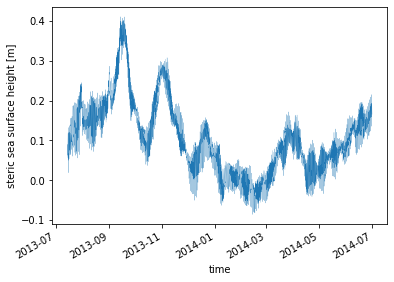

In [19]:
plt.figure()
myds2['eta_steric'].isel(Nc=0).plot(lw=0.2)

In [20]:
# Calculate the Coriolis frequency

Nc = 1

ypt =lat= myds2['yv'].isel(Nc=Nc).values
xpt = myds2['xv'].isel(Nc=Nc).values

f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_cpd = np.abs(f_coriolis*86400/(2*np.pi))
f_cpd, f_coriolis



(0.48142094757951426, -3.500991926388979e-05)

In [21]:
from scipy import signal

4096 (8425,)
Length of each segment [days]:  170.66666666666666
4096 (8425,) 0.005859375 0.005859375
17.858519636878714 17.74328571101463 1.0064945088379291


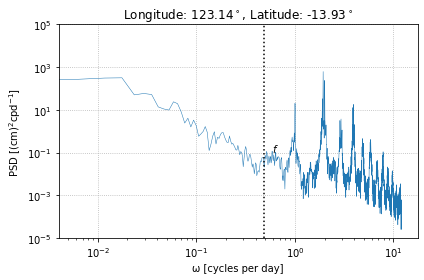

In [22]:
# Compute the power spectrum of the signal
u=myds2['eta_steric'].isel(Nc=Nc)
time = u.time.values
nperseg = 2**12


# dt = (time[1]-time[0]).astype('float')/1e9
dt = 3600.
dt_days = dt/86400

y = u.values * scale
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

print(nperseg, y.shape)
print('Length of each segment [days]: ', nperseg*dt/86400)

# Check the scaling by comparing the signal variance to the integral under the power spectrum
df = f[1] - f[0]
print(nperseg, y.shape, df, np.mean(np.diff(f)))
print(np.var(y-y.mean()), np.trapz(Puu, dx=df), np.var(y)/np.trapz(Puu, dx=df))


plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu, lw=0.5)

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [('+units+')$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-5, 1e5)
ax.axvline(f_cpd, c='k', ls=':')
ax.text(f_cpd+0.1, 1e-1, '$f$')
plt.title('Longitude: {:3.2f}$^\circ$, Latitude: {:3.2f}$^\circ$'.format(xpt,ypt))
plt.tight_layout()

# \n Water Depth: {:3.1f} m total_depth

In [23]:
# Use the sfoda timeseries class to do the filtering
from sfoda.utils.timeseries import timeseries


In [24]:
time = myds2['time'].values
T = timeseries(time, myds2['eta_steric'].isel(Nc=Nc).values,)

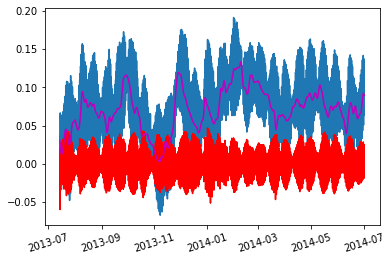

In [25]:

T_tidal = timeseries(myds2['time'].values, T.filt([34*3600, 6*3600], btype='band'))
T_low = timeseries(myds2['time'].values, T.filt([34*3600], btype='low'))

T.plot()
T_tidal.plot(c='r')
T_low.plot(c='m')

/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/sfoda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


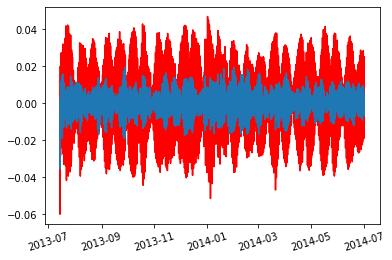

In [26]:
amp, phs, frq, mean, yfit, yrms  = T_tidal.tidefit(frqnames=['M2','S2','N2','K1','O1','P1','Q1'])
T_stat = timeseries(time, yfit)
T_nonstat = timeseries(time, T_tidal.y - yfit)

T_tidal.plot(c='r')
T_nonstat.plot()

(4e-05, 0.0003)

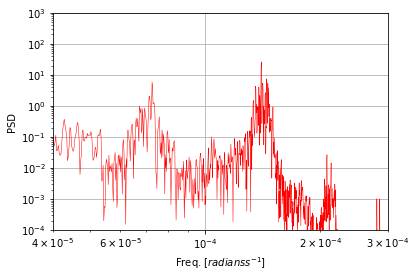

In [28]:
# T_tidal.psd()
T_nonstat.psd(c='r',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

# Estimate the spectral parameters with a GP

In [29]:
from gptide import cov
from gptide import GPtideScipy, GPtideToeplitz
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az

from scipy import stats
from gptide import stats as gpstats

In [30]:
def oscillate_1d(x, xpr, params, itfunc=cov.matern32):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def oscillate_M2S1(x, xpr, params, lt = [12.42/24, 1.], itfunc=cov.matern32):

    eta1, d1, eta2, d2 = params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    return C

def oscillate_M2S2S1(x, xpr, params, lt = [12.42/24, 12/24, 1.], itfunc=cov.matern32):

    eta1, d1, eta2, d2,eta3, d3= params
    
    C = oscillate_1d(x, xpr, (eta1, d1, lt[0]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta2, d2, lt[1]), itfunc=itfunc)
    C += oscillate_1d(x, xpr, (eta3, d3, lt[2]), itfunc=itfunc)

    return C

CPU times: user 28.2 s, sys: 4.09 s, total: 32.3 s
Wall time: 27.9 s


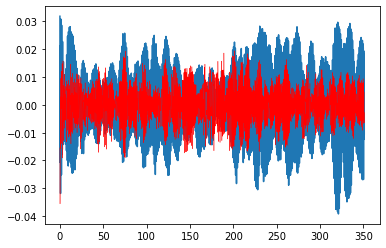

In [31]:
%%time


tdays = (time-time[0]).astype(float)/1e9/86400
X = tdays[:,None]


covfunc = oscillate_M2S2S1
eta1 = 0.007
eta2 = 0.006
eta3 = 0.005
dt1 = 20.
dt2 = 20
dt3 = 10

noise = 0.001

cov_kwargs = {'itfunc':cov.matern32}
#####

covparams = (eta1, dt1, eta2, dt2, eta3, dt3)

GP_s = GPtideScipy(X, X.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.plot(X, zd)
plt.plot(X, T_nonstat.y,'r', lw=0.4)

(4e-05, 0.0003)

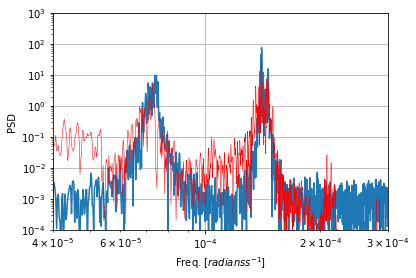

In [32]:
T_nonstat_guess = timeseries(time, zd.ravel())

T_nonstat_guess.psd()
T_nonstat.psd(c='r',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

In [33]:
%%time
GP_s.log_marg_likelihood(zd)

CPU times: user 113 ms, sys: 4 ms, total: 117 ms
Wall time: 115 ms


44527.87639922189

In [34]:
%%time
GP = GPtideToeplitz(X, X.copy(), noise, covfunc, covparams, cov_kwargs=cov_kwargs)


CPU times: user 4.6 ms, sys: 662 µs, total: 5.26 ms
Wall time: 4.23 ms


In [35]:
%%time
GP.log_marg_likelihood(zd)

CPU times: user 247 ms, sys: 535 µs, total: 247 ms
Wall time: 246 ms


44527.87639922449

In [38]:
from gptide import mle

In [39]:
mle?

In [68]:
%%time
# Initial guess of the noise and covariance parameters (these can matter)
noise_ic = 0.001
covparams_ic = [eta1, dt1, eta2, dt2, eta3, dt3]

# There is no mean function in this case
# meanfunc = None
# meanparams_ic = ()
eps=1e-7
bounds = [(eps,1), (eps,1), (eps,1000), (eps,1), (eps,1000), (eps,1), (eps,1000)]
soln = mle(
    X, 
    T_nonstat.y.data[:,None], 
    covfunc, 
    covparams_ic,
    noise_ic,
    GPclass=GPtideToeplitz,
    bounds=bounds,
    method='nelder-mead',
    verbose=False)

soln['x']

CPU times: user 5min 47s, sys: 85.3 ms, total: 5min 47s
Wall time: 5min 47s


array([1.00200013e-07, 4.68139190e-03, 4.74859091e+00, 2.61577223e-03,
       1.83370329e+01, 3.37435186e-03, 9.97485715e-01])

CPU times: user 28.2 s, sys: 4.15 s, total: 32.4 s
Wall time: 27.9 s


(4e-05, 0.0003)

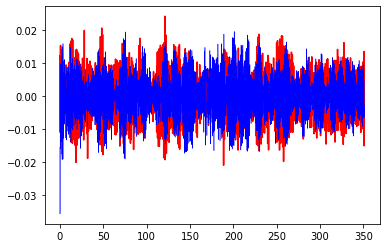

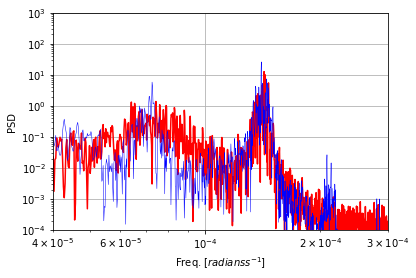

In [69]:
%%time
noise_best=soln['x'][0]
covparams_best=soln['x'][1:]


GP_s = GPtideScipy(X, X.copy(), noise_best, covfunc, covparams_best, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.figure()
plt.plot(X, zd,'r')
plt.plot(X, T_nonstat.y,'b', lw=0.5)

T_nonstat_best = timeseries(time, zd.ravel())

plt.figure()
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)

(0.0001, 0.0002)

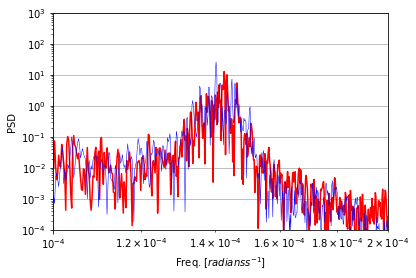

In [70]:
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(1e-4, 2e-4)

# MCMC

In [72]:
from gptide import mcmc

In [79]:
%%time

# Initial guess of the noise and covariance parameters (these can matter)
noise_prior      = gpstats.truncnorm(0.0, 0.1, 1e-15, 1)                 # noise -
covparams_priors = [gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                    gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                    gpstats.truncnorm(0.0, 0.1, 1e-15, 1),   
                    gpstats.truncnorm(20.0, 5, 1e-15, 100),   
                   ]


samples, log_prob, priors_out, sampler = mcmc.mcmc( X, 
                                                    T_nonstat.y.data[:,None],  
                                                    covfunc, 
                                                    covparams_priors,
                                                    noise_prior,
                                                    GPclass=GPtideToeplitz,
                                                    nwarmup=200,
                                                    niter=20,
                                                    nwalkers=100,
                                                    verbose=False)

samples.mean(axis=0)


Running burn-in...


100%|██████████| 200/200 [1:06:21<00:00, 19.91s/it]


Running production...


100%|██████████| 20/20 [06:24<00:00, 19.20s/it]


CPU times: user 1h 13min 35s, sys: 1.65 s, total: 1h 13min 36s
Wall time: 1h 13min 36s


array([1.52707807e-05, 2.00365054e-02, 1.29776745e+01, 4.74488555e-03,
       1.99840282e+01, 7.58266081e-02, 9.58221690e+00])

In [ ]:

%%time
noise_best=samples.mean(axis=0)[0]
covparams_best=samples.mean(axis=0)[1:]


GP_s = GPtideScipy(X, X.copy(), noise_best, covfunc, covparams_best, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP_s.prior(samples=1)

plt.figure()
plt.plot(X, zd,'r')
plt.plot(X, T_nonstat.y,'b', lw=0.5)

T_nonstat_best = timeseries(time, zd.ravel())

plt.figure()
T_nonstat_best.psd(c='r')
T_nonstat.psd(c='b',lw=0.5)
plt.ylim(1e-4,1e3)
plt.xlim(4e-5, 3e-4)